# Causal ML

Source: https://www.pywhy.org/dowhy/v0.11.1/example_notebooks/dowhy-conditional-treatment-effects.html

In [ ]:
# !pip install dowhy econml

In [1]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 생성
실습을 위해 인위적인 데이터를 생성합니다. `dowhy.datasets.linear_dataset`를 사용하여 데이터를 생성하며, 인과 추정을 위한 다양한 변수를 포함합니다.

In [2]:
BETA = 10

data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df = data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -2.249776  1.096470  1.0  0.055706  0.861392  0.181105  3  3  37.432619   
1 -1.781756  0.211874  1.0  0.758787  1.520968 -0.101118  0  2  31.394302   
2  0.081507  0.848169  1.0  0.484777  1.054142 -0.264584  0  0  18.896644   
3 -1.627655  1.247151  1.0  0.093686  0.282241  0.310293  1  2  26.934671   
4 -0.972534 -0.418712  1.0  0.708798  0.449041  0.038440  2  2  36.705274   

            y  
0  236.857274  
1  143.873687  
2  252.928145  
3  240.869823  
4  200.954626  
True causal estimate is 9.871087123469342


## 2. 인과 모델 정의 및 시각화
생성된 데이터를 사용하여 인과 모델을 정의하고, DAG(Directed Acyclic Graph)를 시각화합니다.

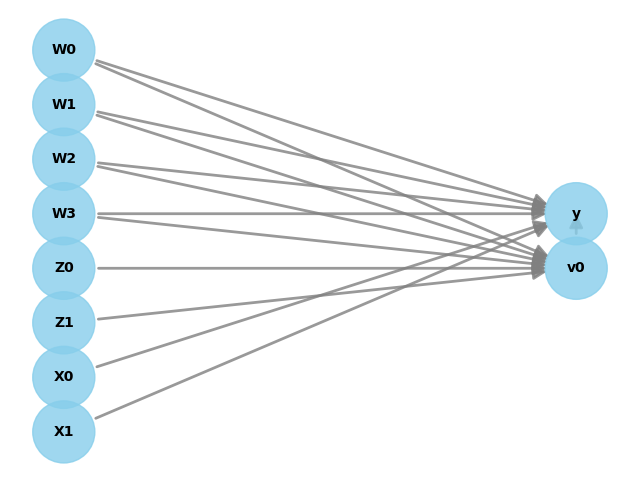

In [3]:
model = CausalModel(data=data["df"],
                    treatment=data["treatment_name"], outcome=data["outcome_name"],
                    graph=data["gml_graph"])

model.view_model()

## 3. DR Learner를 사용한 인과 효과 추정
이제 DR Learner를 사용하여 CATE를 추정합니다.
* Binary 데이터 생성: Binary 처리 변수를 포함하는 데이터를 생성합니다.
* 모델 정의 및 시각화: Binary 데이터를 사용하여 인과 모델을 정의하고, DAG를 시각화합니다.
* 인과 효과 식별: Binary 데이터에서 인과 효과를 식별합니다.
* DR Learner를 사용한 인과 효과 추정: econml 라이브러리를 사용하여 DR Learner를 구현하고, CATE를 추정합니다.

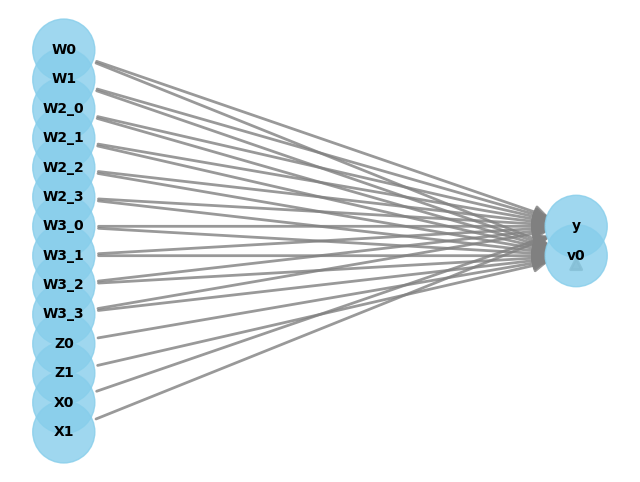

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                      
─────(E[y|W2_3,W2_2,W3_3,W3_0,W3_2,W0,W3_1,W2_1,W2_0,W1])
d[v₀]                                                    
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2_3,W2_2,W3_3,W3_0,W3_2,W0,W3_1,W2_1,W2_0,W1,U) = P(y|v0,W2_3,W2_2,W3_3,W3_0,W3_2,W0,W3_1,W2_1,W2_0,W1)

## Realized estimand
b: y~v0+W2_3+W2_2+W3_3+W3_0+W3_2+W0+W3_1+W2_1+W2_0+W1 | X0,X1
Target units: ate

## Estimate
Mean value: 6.732983481795737
Effect estimates: [[4.63948449]
 [7.27167327]
 [8.01045394]
 ...
 [4.32468582]
 [7.35854245]
 [6.00670483]]

True causal estimate is 6.976589426035168


In [4]:
from sklearn.linear_model import LogisticRegressionCV

# Binary 데이터를 생성합니다.
data_binary = dowhy.datasets.linear_dataset(beta=BETA, num_common_causes=4, num_samples=10000,
                                            num_instruments=2, num_effect_modifiers=2,
                                            num_treatments=1, treatment_is_binary=True,
                                            num_discrete_common_causes=2,
                                            num_discrete_effect_modifiers=0,
                                            one_hot_encode=True)
df_binary = data_binary['df']

model_binary = CausalModel(data=data_binary["df"],
                           treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"],
                           graph=data_binary["gml_graph"])

model_binary.view_model()

identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

drlearner_estimate = model_binary.estimate_effect(
    identified_estimand_binary,
    method_name="backdoor.econml.dr.LinearDRLearner",
    confidence_intervals=False,
    method_params={"init_params":{
        'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
        },
        "fit_params":{}
        }
     )
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

1. Identified Estimand (식별된 추정량): 우리가 추정하려는 인과 효과입니다. 여러 변수를 조정하여 처리(treatment)가 결과에 미치는 영향을 평가합니다.
2. Realized Estimand (실현된 추정량): 실제로 사용된 모델입니다. 이 모델은 여러 변수를 고려하여 결과를 예측합니다.
3. Estimate (추정치): 처리(treatment)가 결과에 미치는 평균적인 효과입니다.
4. True causal estimate (실제 인과 추정 값): 시뮬레이션 데이터에서 실제로 설정한 인과 효과입니다.

# Refute 사례

DoWhy는 인과 추론을 위한 파이썬 라이브러리로, 인과 그래프를 정의하고, 인과 효과를 추정하며, 다양한 방법으로 결과를 반박할 수 있습니다. 여기서는 혼란 변수(confounder)를 통해 반박하는 방법을 살펴보겠습니다.

### 1. 데이터 준비

먼저, 가상의 데이터를 생성합니다. 이 데이터는 두 변수 $X$ (처치 변수)와 $Y$ (결과 변수)가 있으며, 혼란 변수 $Z$가 $X$와 $Y$ 모두에 영향을 미친다고 가정합니다.

```python
import numpy as np
import pandas as pd

# 데이터 생성
np.random.seed(42)
N = 1000
Z = np.random.normal(size=N)
X = 2 * Z + np.random.normal(size=N)
Y = 3 * Z + np.random.normal(size=N)

data = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})
```

### 2. 인과 그래프 정의

DoWhy를 사용하여 인과 그래프를 정의합니다. 여기서는 $Z$가 $X$와 $Y$ 모두에 영향을 미치는 혼란 변수임을 명시합니다.

```python
import dowhy
from dowhy import CausalModel

# 인과 모델 정의
model = CausalModel(
    data=data,
    treatment='X',
    outcome='Y',
    common_causes=['Z']
)
model.view_model()
```

### 3. 인과 효과 추정

DoWhy의 `estimate_effect` 메서드를 사용하여 $X$가 $Y$에 미치는 인과 효과를 추정합니다.

```python
# 인과 효과 추정
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(estimate)
```

### 4. 반박 수행

이제 혼란 변수를 통해 반박을 수행합니다. DoWhy의 `refute_estimate` 메서드를 사용하여 혼란 변수를 추가했을 때 인과 효과 추정이 어떻게 변하는지 확인합니다.

```python
# 혼란 변수 반박
refutation = model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause")
print(refutation)
```

이 예제에서는 혼란 변수 $Z$를 추가하여 반박을 수행했습니다. 반박 결과는 인과 효과 추정이 얼마나 신뢰할 수 있는지 평가하는 데 도움이 됩니다.

이와 같은 예제를 통해 DoWhy를 사용하여 혼란 변수를 통해 인과 효과를 반박하는 방법을 이해할 수 있습니다. 더 자세한 내용은 DoWhy의 공식 문서와 튜토리얼을 참고하시기 바랍니다.